# Solutions
Solutions and code written by Scott Sievert, Ian Kinesella, and Blake Mason.

In [2]:
from IPython.display import Image

* [Warmup](#Warmup)
* [Part 1 (more elastic net stuff)](#Part-1,-more-elastic-net-stuff)
* [Part 2, group lasso](#Part-2,-Group-Lasso)
* [Appendix](#Appendix) (cross validation)

# Warmup
## 1. Derive the Elastic Net prox operator

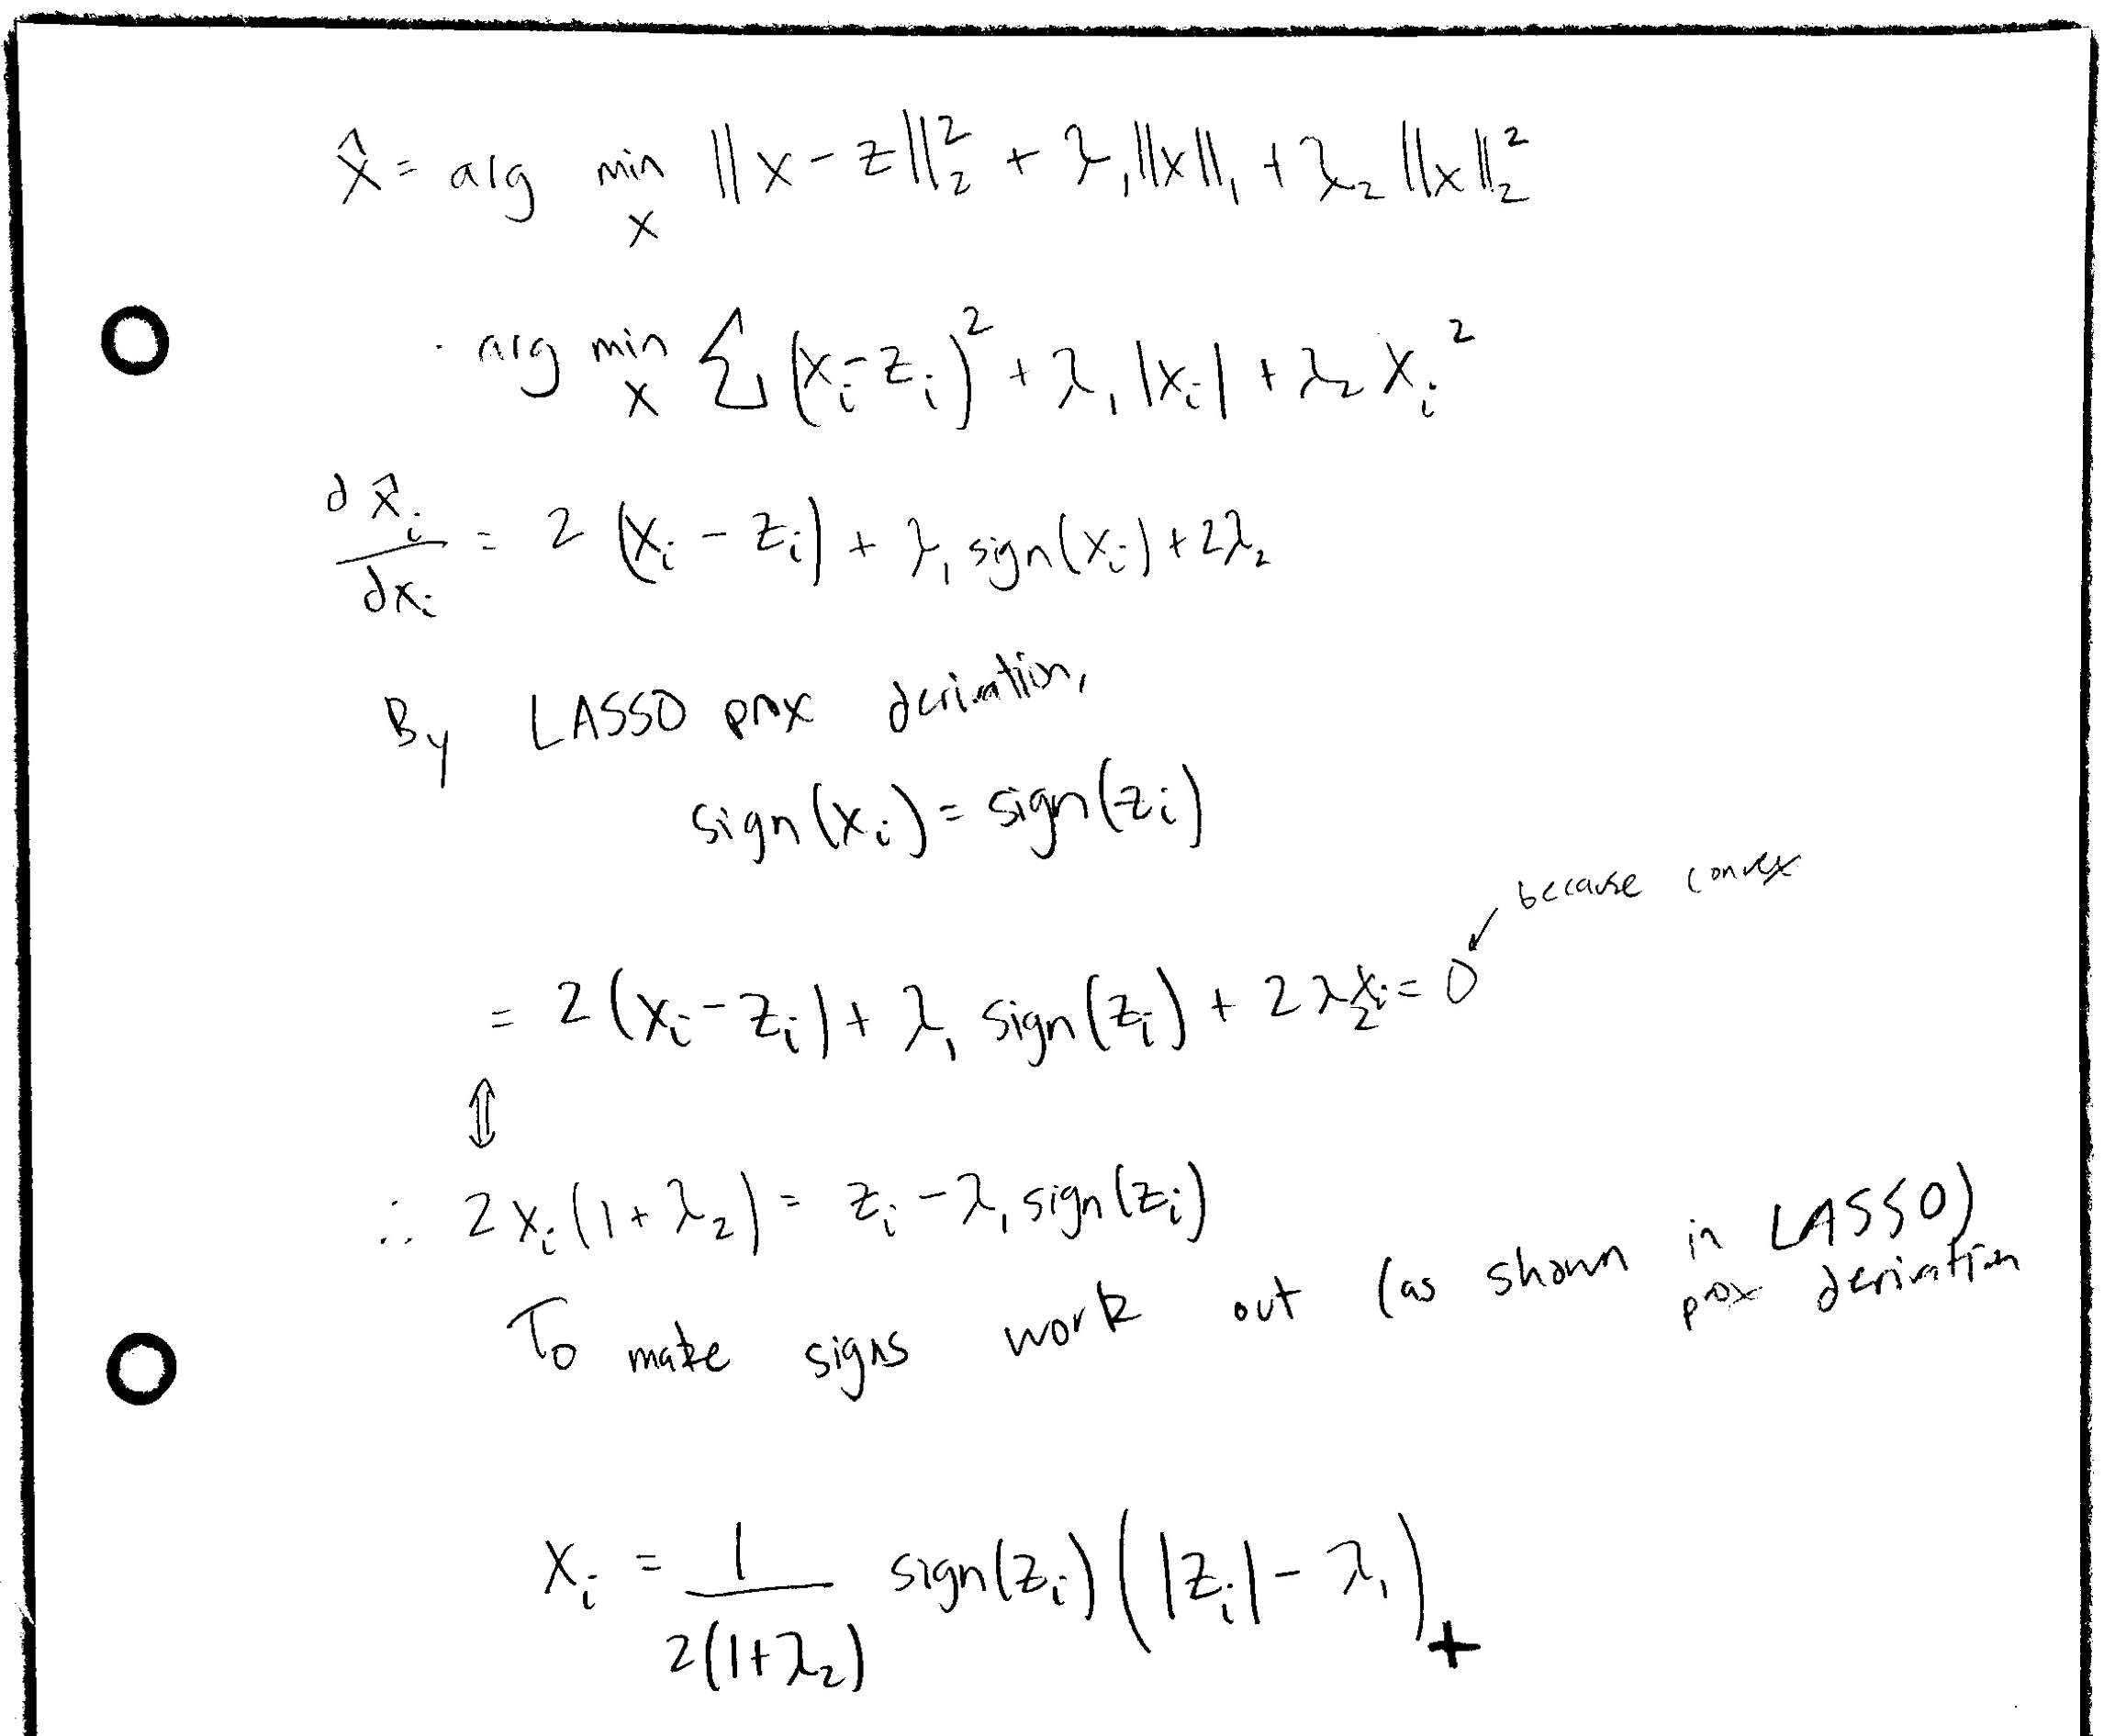

In [3]:
Image(filename='figs/derivation.png')

## 2. Implement Elastic Net

```python
patient = dataset(2);
y = patient.y;
X = dataset.X;

[~, w_hat, ~] = fn.Elastic_Net(X, y, X, y, 30, 0.1);
```

which results in this plot `w_hat`:

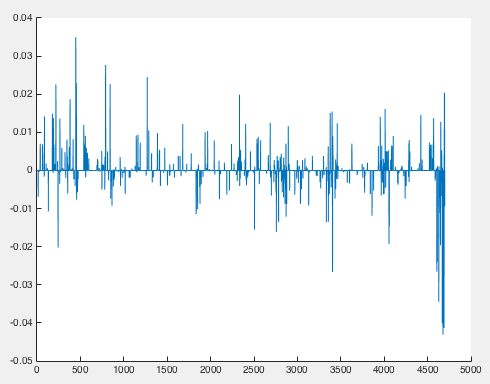

In [4]:
Image(filename='figs/w_hat_enet_warmup.png')


where Elastic Net was defined as below. It should be noted that we used SparRSA to speed up our proximal gradient method, but we implement the prox and loss operators(phi & psi) ourselves.

```python
function [ mse, w_hat, y_hat ] = ...
    Elastic_Net( X_train, y_train, X_test, y_test, lambda, alpha, w0 )
    #% Check Warm Start
    if ~exist('w0')
        w0 = 0;
    end
    #% Regularization Prox and Loss Penalties
    psi = @(x,lambda) soft_shrink(x, lambda, alpha);
    phi = @(x) elastic_norm(x, alpha);
    #% Run SPARSA
    w_hat= SpaRSA(y_train, X_train, lambda,...
        'Psi',psi,...
        'Phi',phi,...
        'Monotone',1,...
        'Debias',0,...
        'Initialization',w0,...
        'StopCriterion',1,...
        'ToleranceA',0.0001, ...
        'ToleranceD',0.000001, ...
        'MaxiterA',100);
    #% Evaluate Results
    y_hat = sign(X_test * w_hat); % Predict On Test Data
    mse = mean(y_hat ~= y_test); %  Calcukate error (raw prediction accuracy, not MSE)
end

function [ y ]= elastic_norm(w, alpha)
    y = (alpha*sum(abs(w(:)))) + ((1-alpha)*norm(w,2));
end

function [ w ] = soft_shrink(w, lambda, alpha)
    % Assign Regulrization
    l1 = alpha * lambda;
    l2 = (1- alpha) * lambda;
    % Shrink With Soft & Group Soft Thresholding
    if alpha == 0
        w =shrink(w, l2);
    elseif alpha == 1
        w = soft_threshold(w, l1);
    else
        w = soft_threshold(w, l1);
        w =shrink(w, l2);
    end
end

function [ w_soft ] = soft_threshold(w, lambda)
    w_soft = sign(w).*max(abs(w) - lambda, 0);
end

function [ w_shrink ] = shrink(w, lambda)
    w_shrink = (w/(1 + lambda));
end
```

Again, note that we used the SpaRSA framework for speed, but this code(prox operators) will work just the same in the standard landweber iteration framework.The complete implementation can be found in `SpaRSA_Models.m`.

# Part 1, more elastic net stuff
## 1. Evaluate your implementation
Done. I ran cross validation, as found in `crossval_script.m`. The output from `crossval_script.m` is shown below and can also be found at the bottom of the scipt. The results reported contain information and important takeaways.

## 2. Number of non-zeros
As shown in the output below, this quantity increases with decreasing alpha. changes with $\alpha$ -- we're changing how important the $\ell_1$ norm is relative to the $\ell_2$ norm. Because the $\ell_1$ norm is an approximation for the $\ell_0$ norm, this means we're emphasizing how important it is that we find a solution with many zeros.

For example, if we hold $\lambda = 37.279$ and vary $\alpha$ from 0 to 1, we observe the number of non-zeros ranging from 4698 at $\alpha = 0$ to 4 at $\alpha = 1$.

## 3. Highest prediction accuracy
In the `crossval.m` script, we found that the best accuracy was 87.5% when following the standard cross validation protocol, but if we also optimize over alphas we obtain a highest average prediction accuray of 92.2%. This makes sense as it allows an extra degree of freedom in constructing the model and may lead to a better solution after cross validation has been used to select the best set of parameters. Also, it is important to note that the performance of plain $\ell_1$ and $\ell_2$ regularization are included in this script, as $\alpha  =1$ and $\alpha = 0$ respectively.

## 4. When might you use elastic net as opposed to pure $\ell_1$ and $\ell_2$?
* $\ell_1$ tends to select a sparse solution. You might add a $\ell_2$ regulization parameter if you have a sparse solution but your solution is known to have several correlated features (because lasso will only select one correlated variable to get the sparsest solution). However, elastic net is not always the best choice for obtaining sparse solutions with correlated features (other algorithms like OSCAR and OWL tend to work very well when the features are highly correlated).
* If you're performing deconvolution, and your input values are known to be sparse in some basis *and* are relatively close to 0.
* When you know that there is an energy constraint on your system but would like to remain sparse in some basis.

Output from cross_val: 
These first results were obtained by also optimizing over alpha values in the cross validation script. Notice how the highest accuracy on the hold out sets align with the folds that yielded the sparsest solutions. This tells
us something important about our signal, that it is sparse and the noise is contained in many other features.

```python
nnz_coef =
        3546
         618
        2455
         194
        1754
        3191
         924
        2537
         644
        2601

err =
    0.1250
         0
    0.1250
         0
    0.1250
    0.1250
         0
    0.3750
         0
    0.5000
```

These results were obtained following the standard cross validation protocol. They are presented in order of increasing alpha = [0,.25,.5,.75,1] (l2->l1). The important thing to note here is that all the non-zero alphas performed better than the alpha=0 (ridge). This is consistent with our beliefe that the signal we are trying to recover is sparse. Just to emphasize this point, note that that alpha=1 (LASSO) had the sparsest solution while alpha=0 (Ridge Regression) yields the largest set of selected voxels. Also, it is important to point out the average number of non-zero weights obtained by the E-net increases with decresing alpha, but the prediction accuracy does not decrease. This is preferrable for robustness/interpretability with low alpha as we can capture more correlated voxels as opposed to only selecting a subset that are capable of giving a good prediction rate.

```python
err_avg

err_avg =

    0.2000    0.1250    0.1250    0.1250    0.1250

nnz_avg

nnz_avg =

   1.0e+03 *

    4.9470    2.3456    1.6535    1.5768    1.4289
```

# Part 2, Group Lasso
## 1. Implement group lasso
Note that we used SpaRSA to make this algorithm run fast. We implemented the prox and loss operators separaely. The structure for this code can be found in `Lasso.py` where we implement Lasso, defining the prox and lasso operators as functions (just like we do here).

The complete and working implementaiton can be found in `SpaRSA_Models.m`, but we have outlined a rough sketch here.

```python
function [ mse, w_hat, y_hat ] = ...
    Group_LASSO( X_train, y_train, X_test, y_test, lambda, groups, w0 )
    % Check Warm Start
    if ~exist('w0')
        w0 = 0;
    end
    % Regularization Prox and Loss Penalties
    psi = @(x,lambda) group_soft_threshold(x, lambda, groups);
    phi = @(x) group_l2norm(x, groups);
    % Run SPARSA
    w_hat= SpaRSA(y_train, X_train, lambda,...
        'Psi',psi,...
        'Phi',phi,...
        'Monotone',1,...
        'Debias',0,...
        'Initialization',w0,...
        'StopCriterion',1,...
        'ToleranceA',0.0001, ...
        'ToleranceD',0.000001, ...
        'MaxiterA',100);
    % Evaluate Results
    y_hat = sign(X_test * w_hat); % Predict On Test Data
    mse = mean(y_hat ~= y_test); % Calcukate error (raw prediction accuracy, not MSE)
end

function [ w_gs ] = group_soft_threshold(w, lambda, groups )
    M = size(groups, 2); % Number of Distinct Groups
    sizes = sqrt(sum(groups, 1)); % sqrt of group sizes
    norms = sqrt(w'.^2*groups); % group l2 norms
    z = norms > 0; % avoid dividing by group norm if already 0
    factors = zeros(1, M); % factors by which to multiply groups
    factors(z) = max(ones(1, sum(z)) - ((lambda * sizes(z))./norms(z)), 0);
    w_gs = (factors*groups')'.*w; % scale elements in groups
end

function [ y ]= group_l2norm(w, groups)
    num_groups = size(groups, 2);
    y = 0;
    groups = (linspace(1, num_groups, num_groups)*groups')';
    for i=1:num_groups
        thisgroup = find(groups == i);
        y = y + norm(w(thisgroup),2);
    end
end
```


## 2. Cross validation
Implemented, and the output (the error rate and number of nonzeros) are displayed below and can be found in `crossval_script.m`.


## 3. Analyze results, compare with elastic net

### Group Lasso and Elastic Net Behavior
We found that group lasso tends to select entire groups to be entirely active or inactive. For example the assumption it makes is that entire clusters of voxels in the brain are all involved or inactive while representing a certain stimuli. On the other hand, Elastic net tends to only select a few features that contin signal important. These features might not show up in groups, like group lasso emphasizes. However, it also means that the solution can contain features from many groups

The following plots compare a representative feature vector that is found with Elastic Net to one found by group LASSO with $\lambda = 12.58$ and has a prediction accuracy of 59.26%.

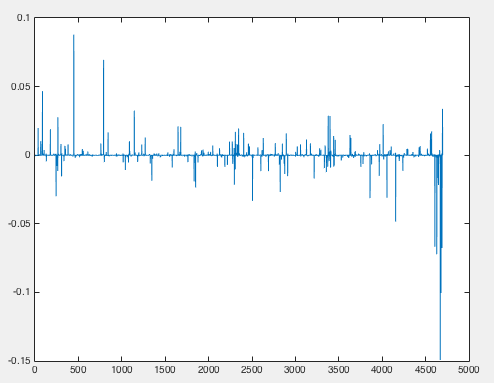

In [5]:
Image(filename='figs/w_hat_enet.png')

In [3]:
Image(filename='figs/w_hat_glasso.png')

NameError: name 'Image' is not defined

### Comparison With Elastic Net
Important to note that the group LASSO did not do perform as well as Elastic Net. This is due to the fact that
it selected entire groups as all or nothing. If we look at the features selected, we notice that small values of lamba were chosen so that almost every group was active. This could be the result of the signal-containing voxels being spread across many different ROI's. In selecting these voxels, the group lasso also pulled in mnay other irrelevant feeatures. This would yield performance very similar to ridge regression. The fact that it did not perform well could
lead us to believe one or more of these three things:

1. The Group Structured signal was not actually present in the groups we defined. Maybe if we had a different way of detecting groups (overlapping group lasso for example) we could do better.

2. The signal within the groups was actually sparse, meaning that we would want to use something like the sparse group lasso which to select the few relevant features form each group, thereby eliminating more noise.

3. The Signal we are looking for isn't even by any means we could infer, so we are shooting ourselves in the foot by using the group lasso.


Group Lasso cross validation results:

Notice how nearly all of the features were selected on every run, this may indicate that our signal is spread across many groups
err

err =

    0.1250
    0.2500
    0.1250
    0.2500
         0
    0.2500
         0
    0.2500
    0.2500
    0.1250

err_avg

err_avg =

    0.1625
nnz_coef

nnz_coef =

        4949
        4947
        4949
        4947
        4946
        4946
        4801
        4947
        4945
        4948

        nnz_avg

nnz_avg =

   4.9325e+03


# Appendix
## Cross validation code
This is a script to perform the cross validation (*sigh* it doesn't teach much but is long and tricky).


```python
clear all; close all; clc;
#%% Load Data & Set Params
fn = SpaRSA_Models();
load('fMRIGroup.mat'); #% provides dataset called "dataset"

testing_function = 'group_lasso'; #% 'group_lasso' or 'enet'

lambda_low = -2;
lambda_high = 2;
num_lambdas = 10;
num_alphas = 5;
num_outer = 10;
num_inner = num_outer-1;

subject = dataset(2);
labels = subject.y;
data = subject.X;
grps = subject.roi;
#% The groups are not the same size as A; let's fix that putting all the
#% stray voxels in their own group
num_grp = size(grps,1);
num_grpd = size(grps,2);
num_feat = size(data,2);
grps = [grps zeros(num_grp, num_feat - num_grpd); zeros(1, num_feat)];
grps(end, sum(grps)==0) = grps(end, sum(grps)==0) + 1;

#%% Cross Validation loop
#% Ian's function will take inputs of train and test data
if strcmp(testing_function, 'group_lasso'),
    num_alphas = 1;
end
CVouter = cvpartition(labels, 'k', num_outer);
err = zeros(CVouter.NumTestSets, num_alphas);
nnz_coef = zeros(CVouter.NumTestSets, num_alphas);

for i = 1:CVouter.NumTestSets
    disp('****')
    disp(i);
    Errors_ = zeros(num_alphas, num_lambdas, 5);
    alpha_vals = linspace(0,1,num_alphas);
    lambda_vals = logspace(lambda_high, lambda_low, num_lambdas);
    
    trainIdx = CVouter.training(i);
    holdIdx = CVouter.test(i);
    
    #% Separate test and training sets for the 10 fold
    #% Xtr_out == X_train_out
    Xtr_outer = data(trainIdx,:);
    ytr_outer = labels(trainIdx);
    Xtest_outer = data(holdIdx,:);
    ytest_outer = labels(holdIdx);
    
    CVinner = cvpartition(labels(trainIdx), 'k', num_inner);
    for j = 1:CVinner.NumTestSets
        #% Separate test and training sets for the 9 fold
        X_train = Xtr_outer(CVinner.training(j),:);
        y_train = ytr_outer(CVinner.training(j));
        X_test = Xtr_outer(CVinner.test(j),:);
        y_test = ytr_outer(CVinner.test(j));
        
        #% Do a grid search over all alphas and all lambdas
        i2 = 0;
        w_hat = zeros(size(X_train, 2), 1);
        for alpha = alpha_vals
            i2 = i2 + 1;
            j2 = 0;
            for lam = lambda_vals
                j2 = j2 + 1;
                if strcmp(testing_function, 'enet'),
                    [error_, w_hat, ~] = fn.Elastic_Net(X_train, y_train, X_test, ...
                        y_test, lam, alpha, w_hat);
                end
                if strcmp(testing_function, 'group_lasso'),
                    [error_, w_hat, ~] = fn.Group_LASSO(X_train, y_train, X_test, ...
                        y_test, lam, grps, w_hat);
                end
                #%disp(error_)
                non_zeros = sum(abs(w_hat) > 1e-6);
                Errors_(i2, j2, 1:4) = Errors_(i2, j2, 1:4) + ...
                    reshape([1.0*error_, non_zeros, lam, alpha], [1,1,4])...
                    / CVinner.NumTestSets;
            end
        end
        j
    end
    #% pick best lambda for each alpha
    best_lambdas_inds = zeros(num_alphas,1);  #% vector of indexs of best lambda
    best_Errors_ = zeros(num_alphas,1);
    for al = 1:size(Errors_,1)
        #% find largest lambda w/in 10% of minimum
        Errors_(al,:,5) = (Errors_(al,:,1) - 1.1*min(Errors_(al,:,1))) <= 1e-6;
        best_lambdas_inds(al) = find(Errors_(al,:,5) == 1, 1, 'first');
        best_Errors_(al) = Errors_(al, best_lambdas_inds(al),1);
        #% Retrain with best lambda, get Final Fit
        w_hat = zeros(size(X_train, 2), 1);
        if strcmp(testing_function, 'enet'),
            [err(i, al), w_hat, ~] = fn.Elastic_Net(Xtr_outer, ytr_outer,...
                Xtest_outer, ytest_outer, lambda_vals(best_lambdas_inds(al)),...
                alpha_vals(al), w_hat);
        end
        if strcmp(testing_function, 'group_lasso'),
            [err(i, al), w_hat, ~] = fn.Group_LASSO(Xtr_outer, ytr_outer,...
                Xtest_outer, ytest_outer, lambda_vals(best_lambdas_inds(al)),...
                grps, w_hat);
        end
        nnz_coef(i, al) =  sum(abs(w_hat) > 1e-6);
    end
end

#% calculate average error:
err_avg = mean(err);
nnz_avg = mean(nnz_coef);

```